<a href="https://colab.research.google.com/github/marcyqz/handwritingOCR/blob/main/handwritingOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip handwriting_data.zip

Archive:  handwriting_data.zip
   creating: handwriting_data/
   creating: handwriting_data/A/
  inflating: handwriting_data/A/IMG-20250528-WA0010.jpg  
  inflating: handwriting_data/A/IMG-20250528-WA0011.jpg  
  inflating: handwriting_data/A/IMG-20250528-WA0012.jpg  
  inflating: handwriting_data/A/IMG-20250528-WA0013.jpg  
  inflating: handwriting_data/A/IMG-20250528-WA0014.jpg  
  inflating: handwriting_data/A/IMG-20250528-WA0015.jpg  
  inflating: handwriting_data/A/IMG-20250528-WA0016.jpg  


In [2]:
import os

base_path = "/content/handwriting_data"

# List all folders (classes)
print("Folders (classes) found:", os.listdir(base_path))

# Check how many images are in the first class
class_name = os.listdir(base_path)[0]
print(f"\nFirst class: {class_name}")
print("Sample files:", os.listdir(os.path.join(base_path, class_name))[:5])


Folders (classes) found: ['A']

First class: A
Sample files: ['IMG-20250528-WA0010.jpg', 'IMG-20250528-WA0011.jpg', 'IMG-20250528-WA0014.jpg', 'IMG-20250528-WA0015.jpg', 'IMG-20250528-WA0013.jpg']


In [3]:
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

#1 - prepping the image for the cnn
1. ImageFolder - tool that automatically loads and labels your images based on folder names. part of the library torchvision
2. transforms - convert, resize, normalize images
3. DataLoader - packs images into mini-batches
4. torchvision - package of tools for image processing in PyTorch
5. tensor - fancy array to hold data like images, numbers, model weights. can do math with it

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Step 1: Set up image transformations
transform = transforms.Compose([
    transforms.Grayscale(),            # Convert to grayscale
    transforms.Resize((28, 28)),       # Resize all images to 28x28
    transforms.ToTensor(),             # Convert to tensor (PyTorch format)
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Step 2: Load dataset from folders
dataset = datasets.ImageFolder('/content/handwriting_data', transform=transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check classes
print("Class labels:", dataset.classes)
print("Total images loaded:", len(dataset))

Class labels: ['A']
Total images loaded: 7


#2 - defining a simple cnn model
1. torch - main PyTorch library: tensors, neural network layers, training maths, optimizers, models, gpu access.....
2. self - this model instance
3. convolutional layer - like a filter that slides across the image looking for patterns
4. kernel - (filter) small matrix of numbers, slides across the image doing dot product math
5. ReLU - Rectified Linear Unit: math function, keeps the positives

In [5]:
import torch
import torch.nn as nn # neural network layers
import torch.nn.functional as F # activation functions like ReLU

class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)   # convolutional layer: grayscale = 1 channel
        self.pool = nn.MaxPool2d(2, 2)        # downsamples the image to make it smaller, focusing on the strongest signals
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)  # convolutional layer
        self.fc1 = nn.Linear(16 * 5 * 5, 64)  # depends on final output size, fully connected layer
        self.fc2 = nn.Linear(64, 1)           # 1 output class: A
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # conv1 → relu → pool
        x = self.pool(F.relu(self.conv2(x)))  # conv2 → relu → pool
        x = x.view(-1, 16 * 5 * 5)             # flatten
        x = F.relu(self.fc1(x))               # fully connected
        x = self.sigmoid(self.fc2(x))         # final output (probability)
        return x


#3 - Training the model
1. epoch - one complete pass through the entire training dataset

In [9]:
import torch.optim as optim

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = TinyCNN().to(device)

# Binary classification (only one class): use BCE
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5  # You can increase this later
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs, _ in data_loader:  # we ignore labels because there's only 1 class
        inputs = inputs.to(device)
        labels = torch.ones(inputs.size(0), 1).to(device)  # all labels are 1 (for "A")

        optimizer.zero_grad()
        outputs = model(inputs) # runs images through cnn, produces prediction between 0 and 1
        loss = criterion(outputs, labels) # compare prediction to correct label
        loss.backward() # traces the error backwards, claculates how to tweak each layer's weight to reduce the error
        optimizer.step() # applies the tweaks

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss:.4f}") # total error, lower = better


Using device: cpu
Epoch 1/5 | Loss: 1.4068
Epoch 2/5 | Loss: 1.3176
Epoch 3/5 | Loss: 1.2468
Epoch 4/5 | Loss: 1.1646
Epoch 5/5 | Loss: 1.0603


# 4 - testing the model

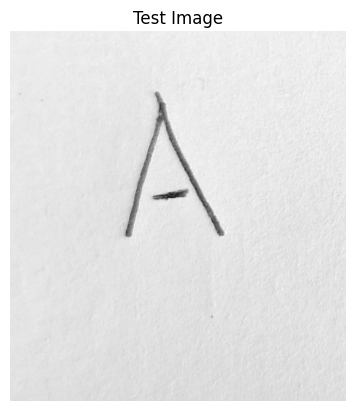

Prediction confidence (is this an A?): 0.6186


In [10]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Path to a test image (change filename if needed)
test_image_path = '/content/handwriting_data/A/IMG-20250528-WA0010.jpg' # "C:\Users\marce\Desktop\handwriting_data\A\IMG-20250528-WA0010.jpg"

# Step 1: Load and display the image
img = Image.open(test_image_path).convert('L')  # convert to grayscale
plt.imshow(img, cmap='gray')
plt.title('Test Image')
plt.axis('off')
plt.show()

# Step 2: Apply same transforms as during training
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

# Step 3: Run through model
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    prediction = output.item()

print(f"Prediction confidence (is this an A?): {prediction:.4f}")
